This notebook is used to run JAX-CANOAK in US-Hn1 site.

# Load the necessary libraries

In [2]:
# # TODO: A more generic way is needed here to load the path
# import sys

# sys.path.append(
#     "/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src"
#     # "/global/homes/p/peishi89/jax-watershed/src"
# )

In [24]:
import optax
import equinox as eqx

from functools import partial

# import numpy as np
import jax
import jax.numpy as jnp
import jax.tree_util as jtu

import pandas as pd

from jax_canoak.subjects import get_met_forcings, initialize_parameters, Obs
from jax_canoak.physics.energy_fluxes import get_dispersion_matrix
from jax_canoak.models import CanoakBase
from jax_canoak.shared_utilities.optim import perform_optimization

import matplotlib.pyplot as plt
from jax_canoak.shared_utilities.plot import (
    plot_daily,
    plot_imshow2,
    plot_timeseries_obs_1to1,
    plot_rad,
    plot_ir,
)
from jax_canoak.shared_utilities.plot import (
    plot_obs_1to1,
    plot_obs_comparison,
    plot_obs_energy_closure,
    plot_dij,
)

# from jax_canoak.shared_utilities.plot import plot_veg_temp, plot_dij
# from jax_canoak.shared_utilities.plot import plot_ir, plot_rad, plot_prof2

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
jax.config.update("jax_debug_infs", False)
# jax.config.update("XLA_PYTHON_CLIENT_ALLOCATOR", 'platform')

%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# Model parameters and settings

In [7]:
time_zone = -8
latitude = 46.4089
longitude = -119.2750
stomata = 0
veg_ht = 1.2
leafangle = 2  # erectophile
n_can_layers = 50
meas_ht = 5.0
soil_depth = 0.15
n_hr_per_day = 48
niter = 15
f_forcing = "../data/fluxtower/US-Hn1/US-Hn1-forcings.csv"

# Load and set the model forcings

In [8]:
met, n_time = get_met_forcings(f_forcing)

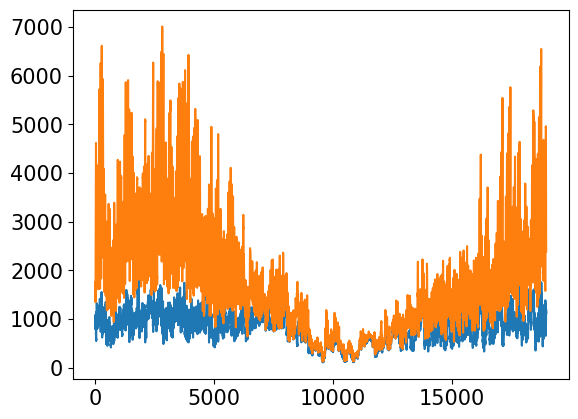

In [9]:
plt.plot(met.eair_Pa)
plt.plot(met.es)

# Create the model parameter instance

In [10]:
setup, para = initialize_parameters(
    time_zone=time_zone,
    latitude=latitude,
    longitude=longitude,
    stomata=stomata,
    veg_ht=veg_ht,
    leafangle=leafangle,
    n_can_layers=n_can_layers,
    meas_ht=meas_ht,
    soil_depth=soil_depth,
    n_hr_per_day=n_hr_per_day,
    n_time=n_time,
    npart=int(1e6),
    niter=niter,
)

# Generate or read the dispersion matrix

In [26]:
# dij = get_dispersion_matrix(setup, para)
dij = get_dispersion_matrix(setup, para, "../data/dij/Dij_US-Hn1.csv")
# np.savetxt("../data/dij/Dij_US-Hn1.csv", np.array(dij), delimiter=',')

<Axes: xlabel='Dij [s/m]', ylabel='Height [m]'>

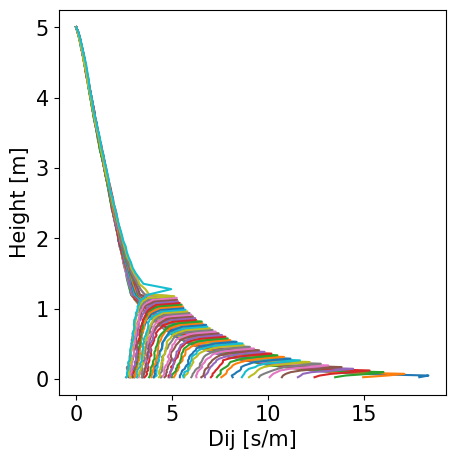

In [12]:
plot_dij(dij, para)

# Run CANOAK!

In [13]:
jax.clear_caches()
canoak_eqx = CanoakBase(para, setup, dij)
(
    _,
    prof,
    quantum,
    nir,
    ir,
    rnet,
    qin,
    sun_ang,
    leaf_ang,
    lai,
    sun,
    shade,
    soil,
    veg,
    can,
) = canoak_eqx(met)

In [14]:
jax.clear_caches()
eqx.filter_make_jaxpr(canoak_eqx)(met)

({ lambda a:f64[50] b:f64[50] c:f64[50] d:f64[50] e:i64[10] f:f64[] g:i64[1] h:f64[]
    i:f64[] j:f64[] k:f64[] l:f64[] m:f64[] n:f64[] o:f64[] p:f64[] q:i64[50] r:i64[50]
    s:i64[50] t:f64[] u:f64[] v:f64[] w:f64[] x:f64[] y:f64[] z:f64[] ba:f64[] bb:f64[]
    bc:f64[] bd:f64[] be:f64[] bf:f64[] bg:f64[] bh:f64[] bi:f64[] bj:f64[] bk:f64[]
    bl:f64[] bm:f64[] bn:f64[] bo:f64[] bp:f64[] bq:f64[] br:f64[] bs:f64[] bt:i64[1]
    bu:i64[1] bv:i64[9] bw:i64[1] bx:i64[1] by:i64[10] bz:i64[1] ca:i64[1] cb:f64[4]
    cc:f64[4] cd:f64[4] ce:f64[100,50]; cf:f64[18960] cg:f64[18960] ch:f64[18960]
    ci:f64[18960] cj:f64[18960] ck:f64[18960] cl:f64[18960] cm:f64[18960] cn:f64[18960]
    co:f64[18960] cp:f64[18960] cq:f64[18960] cr:f64[18960] cs:f64[18960] ct:f64[18960]. let
    cu:f64[100] = concatenate[dimension=0] a b
    cv:f64[100] = concatenate[dimension=0] c d
    cw:f64[18960,100] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(18960, 100)
    ] 1.0
    cx:f64[18960,10

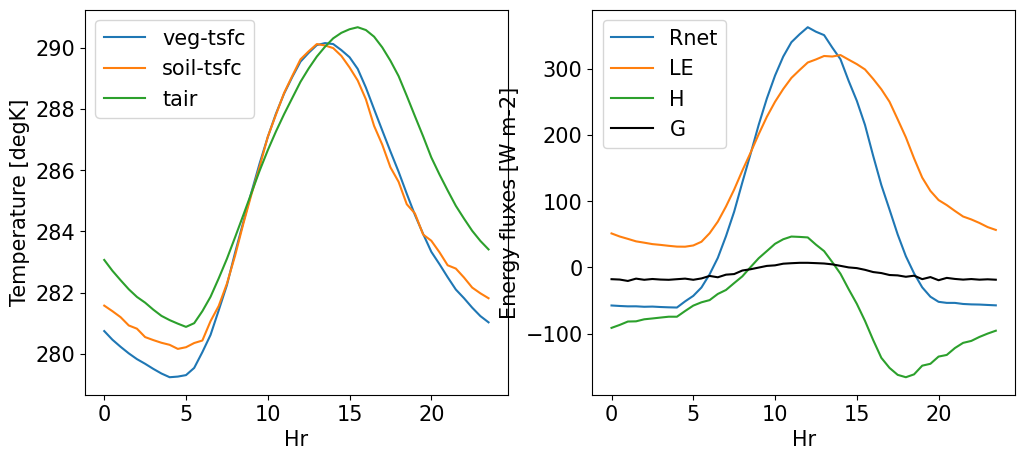

In [15]:
# Daily average
plot_daily(met, soil, veg, para);

<Axes: title={'center': 'IR flux density, W m-2'}, xlabel='Radiation Flux Density', ylabel='Canopy Cumulative LAI'>

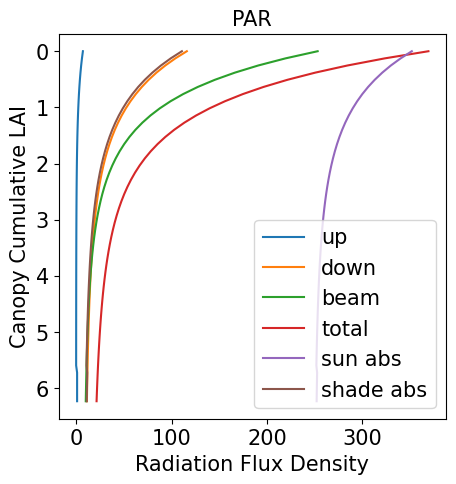

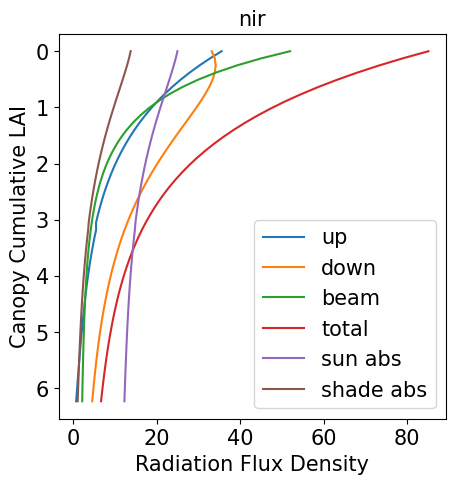

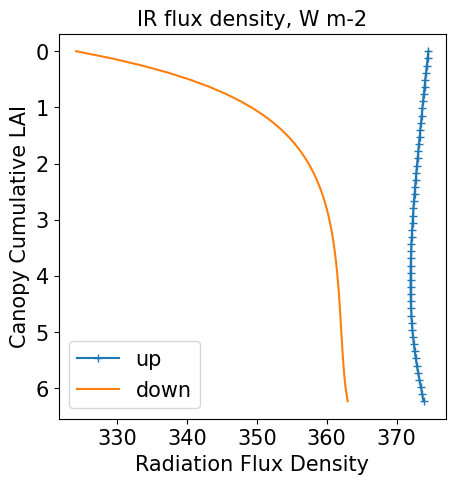

In [35]:
plot_rad(quantum, setup, lai, "PAR")
plot_rad(nir, setup, lai, "nir")
plot_ir(ir, setup, lai)

/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:102: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:102: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:102: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")


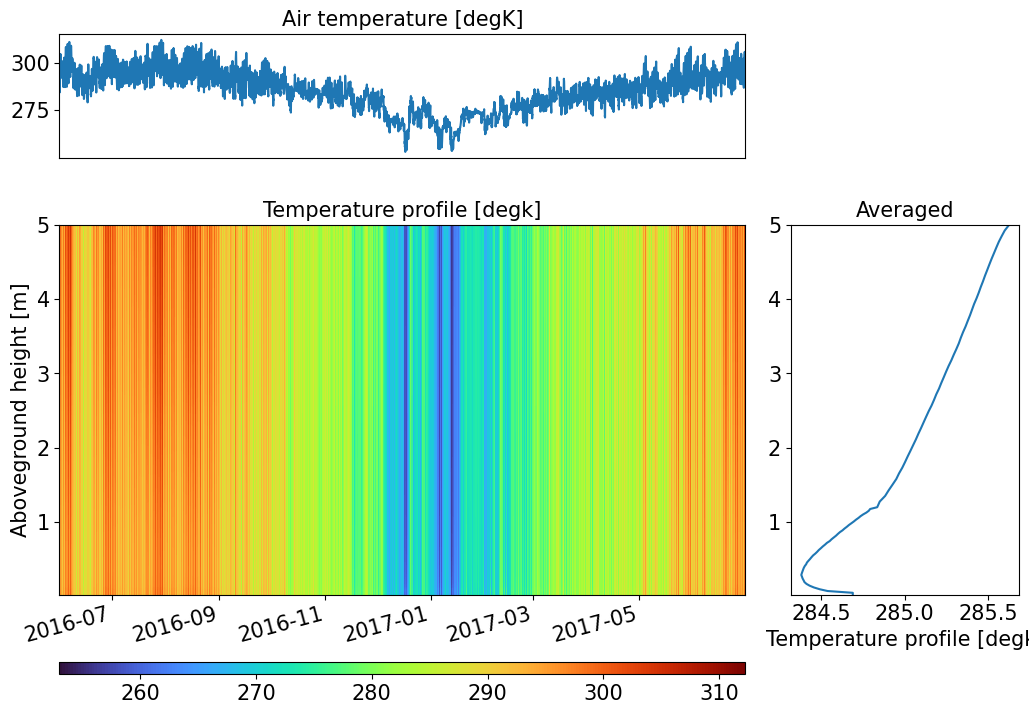

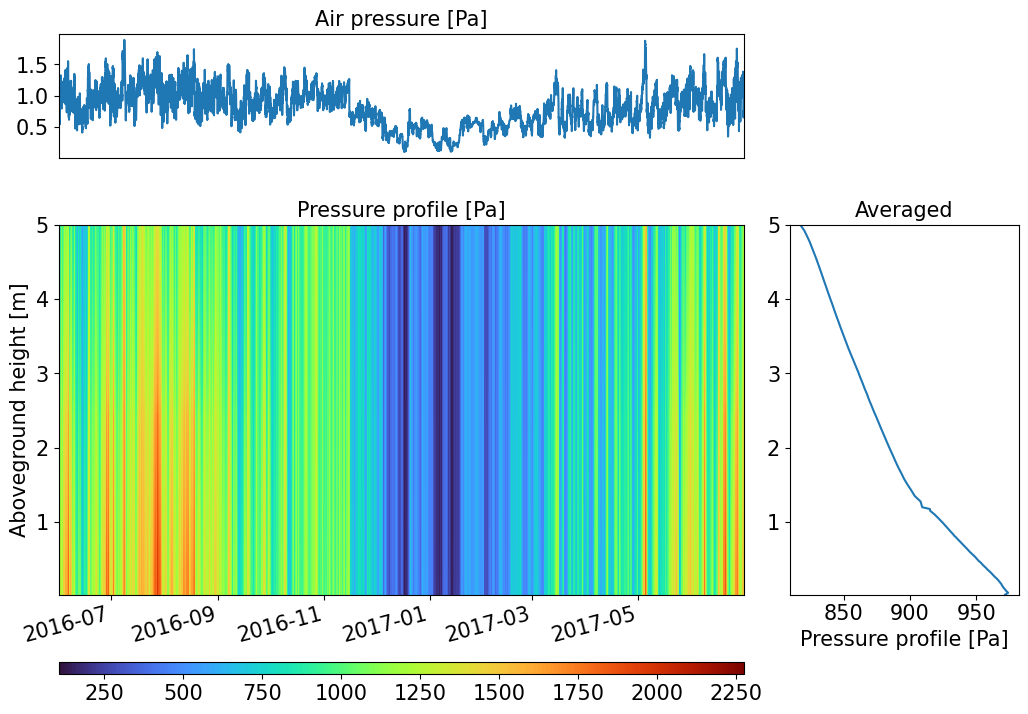

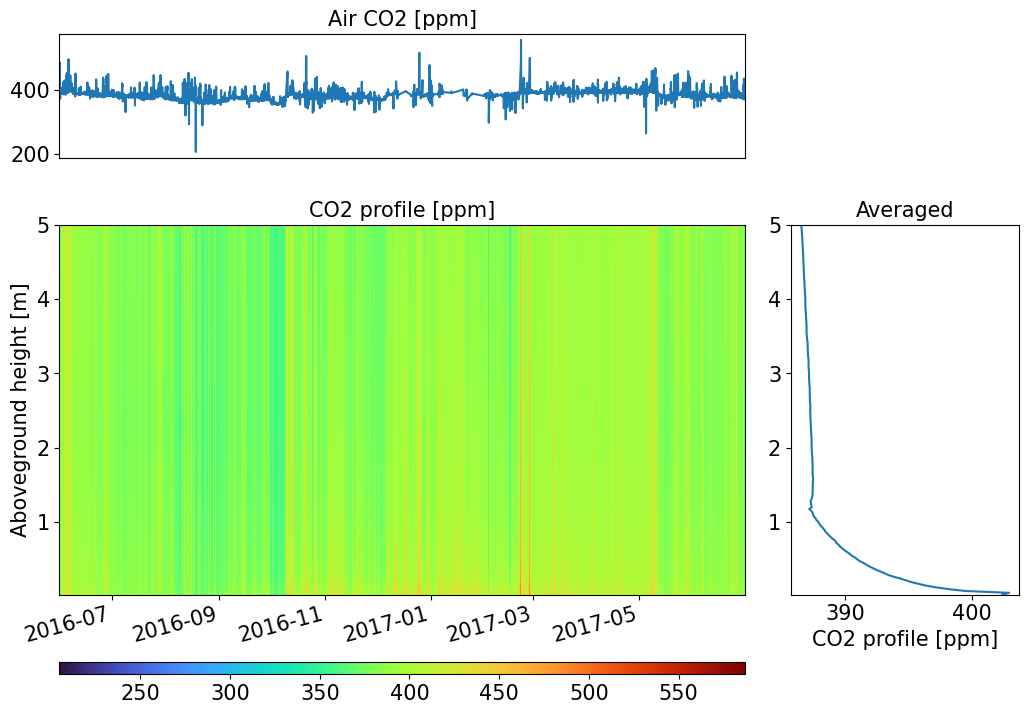

In [36]:
# Profiles
plot_imshow2(
    prof.Tair_K.T,
    met,
    para.zht,
    key="T",
    title="Temperature profile [degk]",
    cmap="turbo",
)
plot_imshow2(
    prof.eair_Pa.T, met, para.zht, key="e", title="Pressure profile [Pa]", cmap="turbo"
)
plot_imshow2(
    prof.co2.T, met, para.zht, key="co2", title="CO2 profile [ppm]", cmap="turbo"
)

/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha='right')
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha='right')
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha='right')


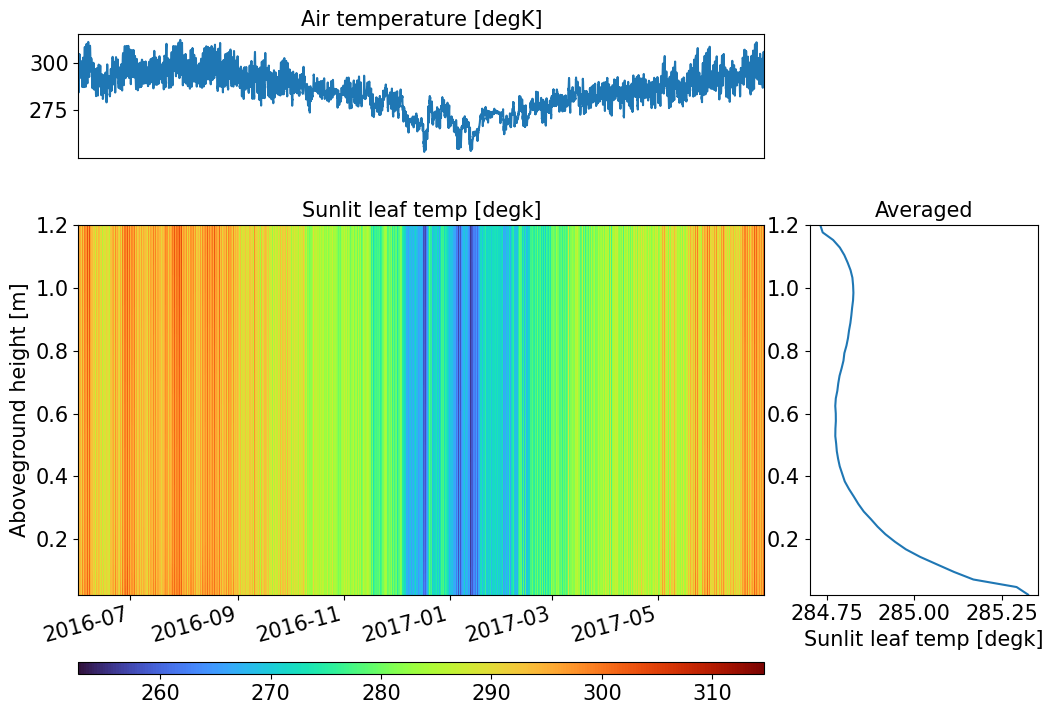

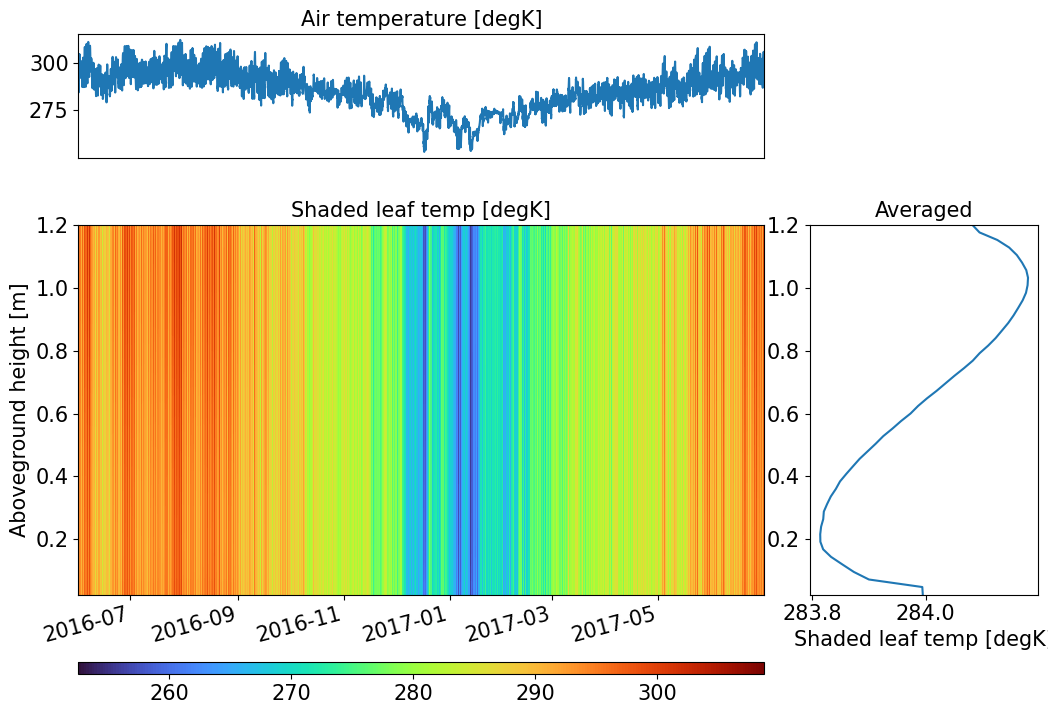

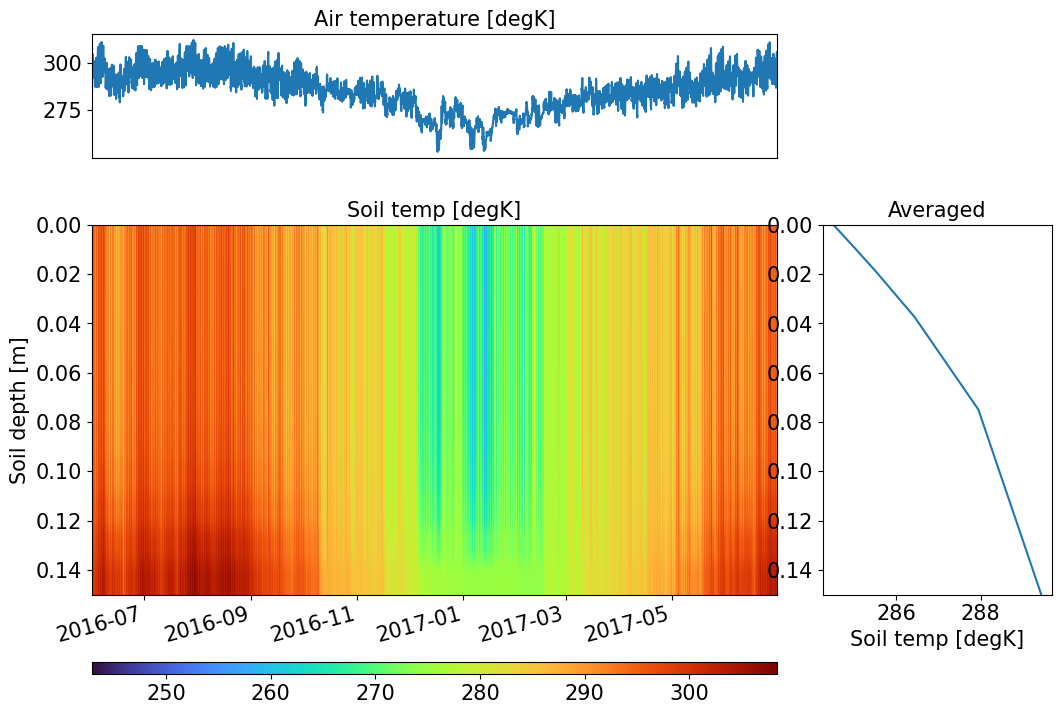

In [14]:
# Temperature
plot_imshow2(
    sun.Tsfc.T, met, para.zht1, key="T", title="Sunlit leaf temp [degk]", cmap="turbo"
)
plot_imshow2(
    shade.Tsfc.T, met, para.zht1, key="T", title="Shaded leaf temp [degK]", cmap="turbo"
)
plot_imshow2(
    soil.T_soil[:, :-1].T,
    met,
    soil.z_soil,
    key="T",
    title="Soil temp [degK]",
    cmap="turbo",
    is_canopy=False,
)

/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha='right')
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha='right')
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha='right')
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xtic

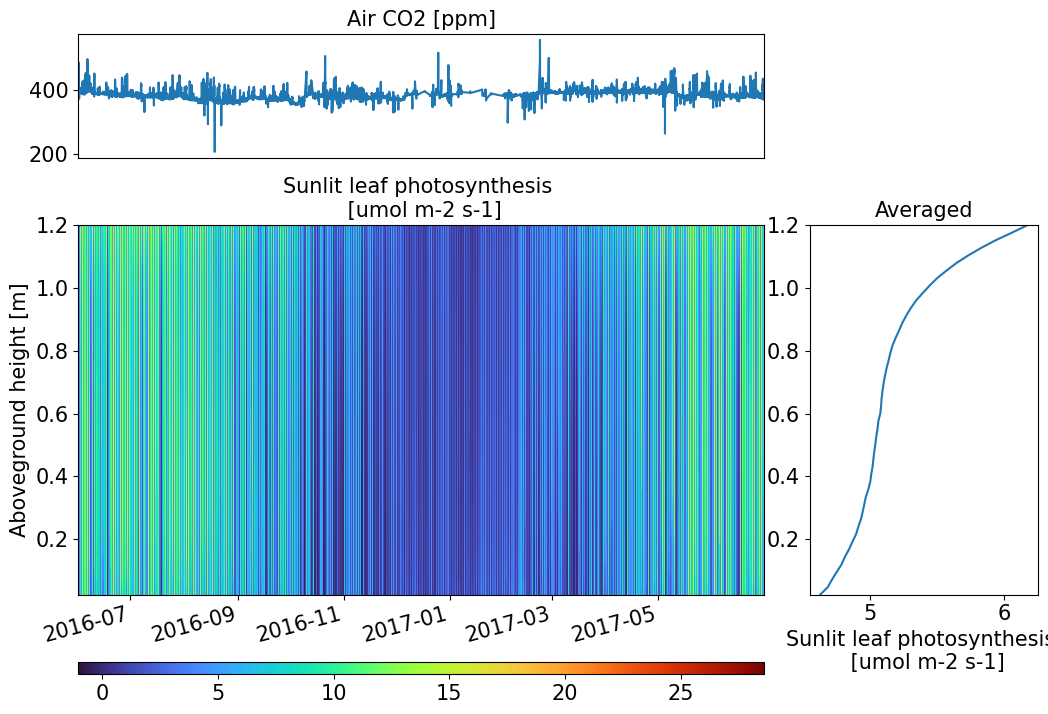

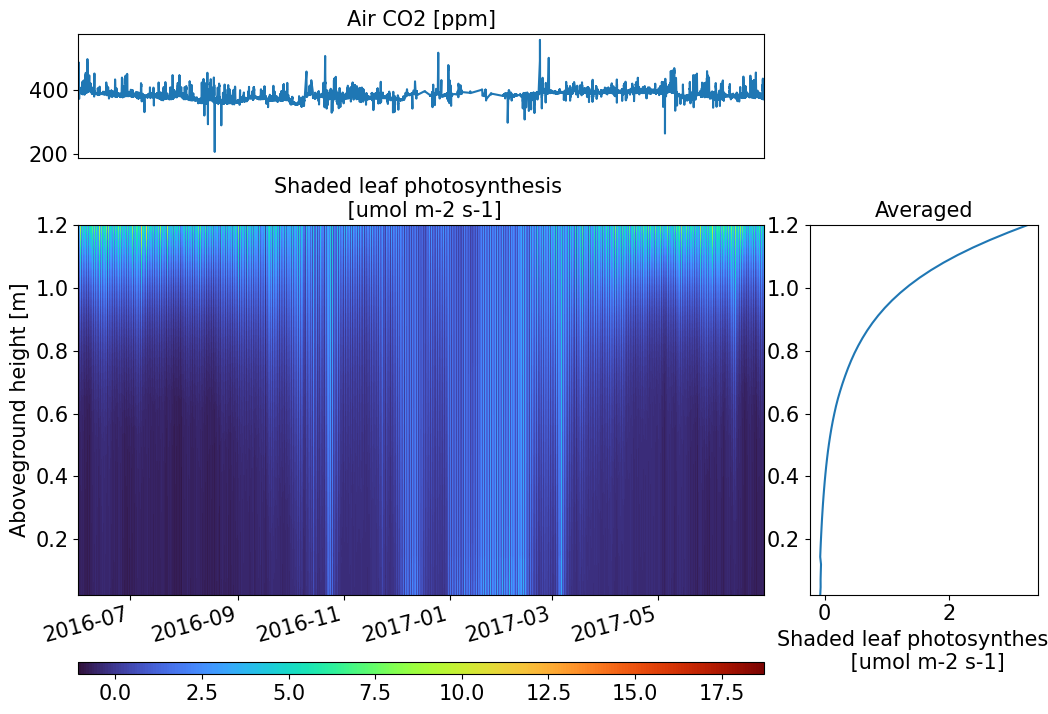

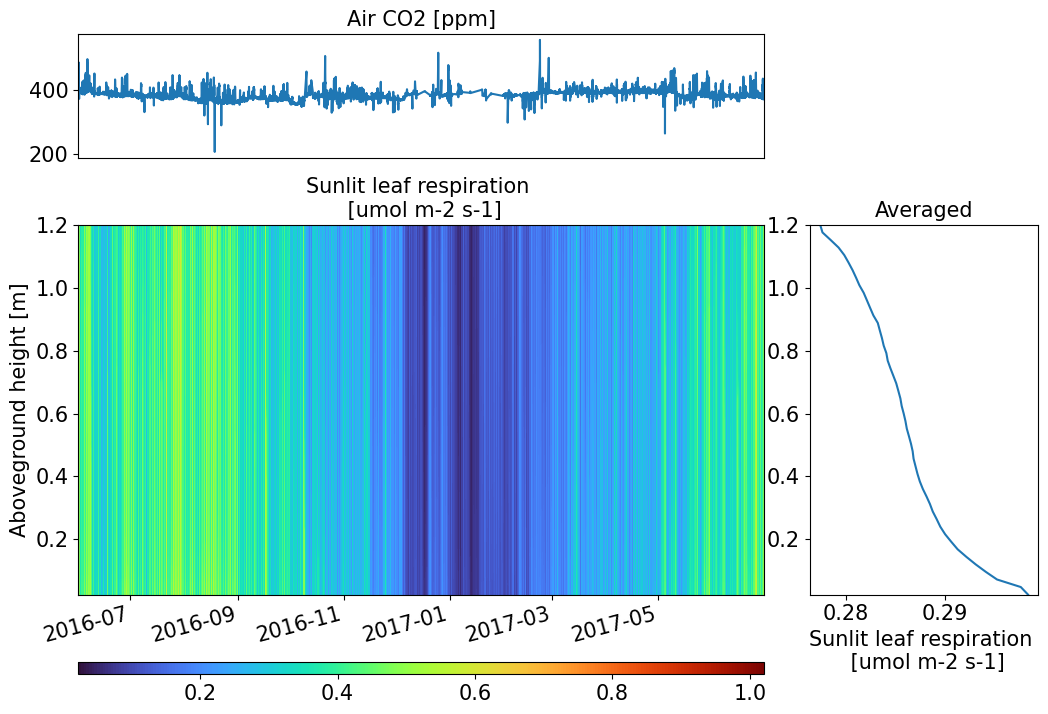

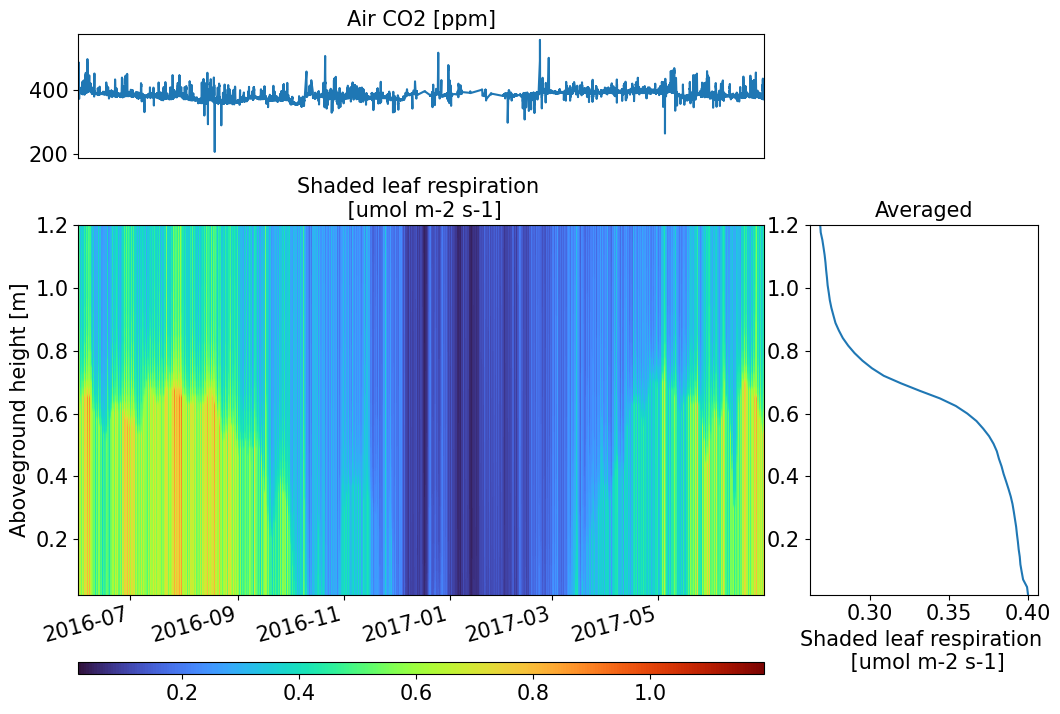

In [15]:
# respiration/photosynthesis
plot_imshow2(
    sun.Ps.T,
    met,
    para.zht1,
    key="co2",
    title="Sunlit leaf photosynthesis \n [umol m-2 s-1]",
    cmap="turbo",
)
plot_imshow2(
    shade.Ps.T,
    met,
    para.zht1,
    key="co2",
    title="Shaded leaf photosynthesis \n [umol m-2 s-1]",
    cmap="turbo",
)
plot_imshow2(
    sun.Resp.T,
    met,
    para.zht1,
    key="co2",
    title="Sunlit leaf respiration \n [umol m-2 s-1]",
    cmap="turbo",
)
plot_imshow2(
    shade.Resp.T,
    met,
    para.zht1,
    key="co2",
    title="Shaded leaf respiration \n [umol m-2 s-1]",
    cmap="turbo",
)

In [14]:
# met2 = jax.tree_util.tree_map(lambda x: x.reshape(1,816), met)
# jax.vmap(canoak, in_axes=[None,None,0,None,None,None])(para, setup, met2,
#    dij, setup.soil_mtime, setup.niter)

# Local sensitivity analysis

In [18]:
jax.clear_caches()


@eqx.filter_jit
@partial(jax.grad, argnums=0)
def df_canoak_le(para, met, canoak_eqx):
    canoak_eqx = eqx.tree_at(lambda t: t.para, canoak_eqx, para)
    (
        _,
        prof,
        quantum,
        nir,
        ir,
        rnet,
        qin,
        sun_ang,
        leaf_ang,
        lai,
        sun,
        shade,
        soil,
        veg,
        can,
    ) = canoak_eqx(met)
    return can.LE.sum()


# eqx.filter_make_jaxpr(df_canoak_le3)(para, met, canoak_eqx)

## Perform SA at one time step

In [19]:
start, ntime = 20, 1
# setup2 = eqx.tree_at(lambda t: (t.ntime), setup, replace=(ntime))
canoak_eqx2 = eqx.tree_at(lambda t: (t.ntime), canoak_eqx, replace=(ntime))
met2 = jtu.tree_map(lambda x: x[start : start + ntime], met)

In [27]:
eqx.tree_at(lambda t: (t.ntime), canoak_eqx, replace=(ntime))

CanoakBase(
  para=Para(
    zht1=f64[50],
    zht2=f64[50],
    delz1=f64[50],
    delz2=f64[50],
    soil_depth=f64[],
    leaf_clumping_factor=f64[],
    par_reflect=f64[],
    par_trans=f64[],
    par_soil_refl=f64[],
    nir_reflect=f64[],
    nir_trans=f64[],
    nir_soil_refl=f64[],
    sigma=f64[],
    ep=f64[],
    epsoil=f64[],
    rugc=f64[],
    rgc1000=f64[],
    Cp=f64[],
    vcopt=f64[],
    jmopt=f64[],
    rd25=f64[],
    hkin=f64[],
    skin=f64[],
    ejm=f64[],
    evc=f64[],
    kc25=f64[],
    ko25=f64[],
    o2=f64[],
    ekc=f64[],
    eko=f64[],
    erd=f64[],
    ektau=f64[],
    tk_25=f64[],
    toptvc=f64[],
    toptjm=f64[],
    kball=f64[],
    bprime=f64[],
    rsm=f64[],
    brs=f64[],
    qalpha=f64[],
    lleaf=f64[],
    nuvisc=f64[],
    dc=f64[],
    dh=f64[],
    dv=f64[],
    do3=f64[],
    betfac=f64[],
    Mair=f64[],
    dLdT=f64[],
    extinct=f64[]
  ),
  dij=f64[100,50],
  lat_deg=46.4089,
  long_deg=-119.275,
  time_zone=-8,
  leafangle=2,


In [20]:
gradients = df_canoak_le(para, met2, canoak_eqx2)

## Perform SA at multiple steps

In [53]:
jax.clear_caches()
# met_reshaped = jtu.tree_map(lambda x: x.reshape(1,setup.ntime), met)
met_reshaped = jtu.tree_map(lambda x: x.reshape(1, setup.ntime)[:, :100], met)
# met_reshaped = jtu.tree_map(lambda x: x.reshape(1,setup.ntime)[:,20:21], met)
# Forward model
out = jax.vmap(canoak_eqx2, in_axes=[1])(met_reshaped)
# Gradient
gradients_all = jax.vmap(df_canoak_le, in_axes=[None, 1, None])(
    para, met_reshaped, canoak_eqx2
)

In [20]:
jax.profiler.start_trace("./memory_log")
met_reshaped = jtu.tree_map(lambda x: x.reshape(1, setup.ntime)[:, :5000], met)
gradients_all2 = jax.vmap(df_canoak_le, in_axes=[None, 1, None])(
    para, met_reshaped, canoak_eqx2
)
# %memit jax.vmap(df_canoak_le, in_axes=[None,1,None])(para, met_reshaped, canoak_eqx2)
jax.profiler.stop_trace()
jax.profiler.save_device_memory_profile("gradient_vmap_nt5000.json")

2023-09-05 10:30:10.395015: E external/xla/xla/python/profiler/internal/python_hooks.cc:398] Can't import tensorflow.python.profiler.trace
2023-09-05 10:32:03.955139: E external/xla/xla/python/profiler/internal/python_hooks.cc:398] Can't import tensorflow.python.profiler.trace


In [39]:
out = jax.vmap(canoak_eqx2, in_axes=[1])(met_reshaped)

In [34]:
# import sys
# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# # for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
# #                           locals().items())), key= lambda x: -x[1])[:10]:
# #     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

# size = sys.getsizeof(gradients_all.zht1)
# sizeof_fmt(size, suffix='B')

'584.0 B'

## Perform SA at aggregated output

In [56]:
jax.clear_caches()
start, ntime = 20, 100
# setup2 = eqx.tree_at(lambda t: (t.ntime), setup, replace=(ntime))
canoak_eqx3 = eqx.tree_at(lambda t: (t.ntime), canoak_eqx, replace=(ntime))
met3 = jtu.tree_map(lambda x: x[start : start + ntime], met)

gradients3 = df_canoak_le(para, met3, canoak_eqx3)

In [59]:
jax.clear_caches()
gradients4 = df_canoak_le(para, met, canoak_eqx)

: 

: 

# Comparison with the observations

In [38]:
# Read the observations
f_obs = "../data/fluxtower/US-Hn1/US-Hn1-fluxes.csv"
obs = pd.read_csv(f_obs)
obs.interpolate(method="linear", limit_direction="both", inplace=True)
# obs[obs == -9999] = np.nan
# obs = jnp.array(obs)

LE_obs, H_obs = jnp.array(obs["LE"]), jnp.array(obs["H"])
Gsoil_obs, Rnet_obs = jnp.array(obs["G_5cm"]), jnp.array(obs["NETRAD"])

nan = jnp.nan * jnp.ones(LE_obs.size)
GPP_obs, albedo_obs, Fco2_obs = nan, nan, nan

obs = Obs(LE_obs, H_obs, GPP_obs, Rnet_obs, albedo_obs, Fco2_obs, Gsoil_obs)

<Axes: xlabel='Rnet, measured', ylabel='H+LE+Gsoil, measured'>

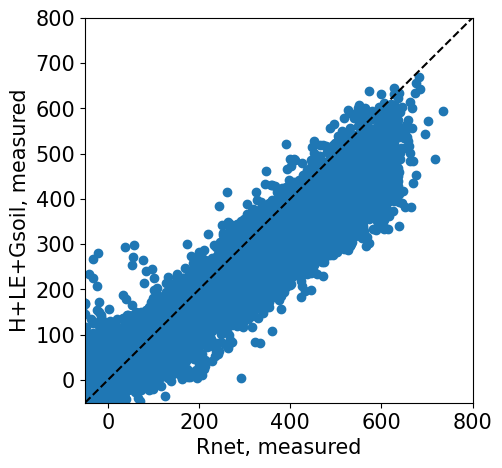

In [39]:
plot_obs_energy_closure(obs)

<Axes: title={'center': 'Rnet (L2: 1369.505)'}, xlabel='Measured', ylabel='Simulated'>

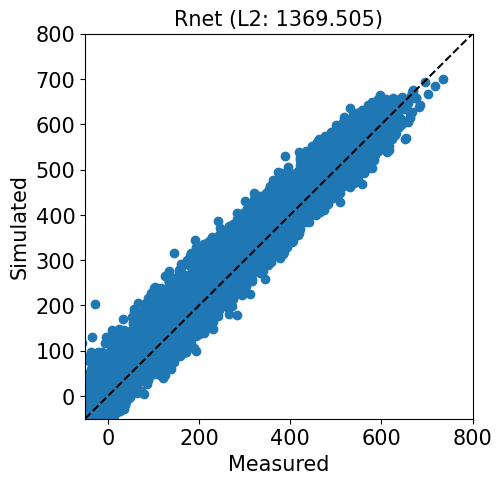

In [40]:
plot_obs_1to1(obs.rnet, can.rnet, lim=[-50, 800], varn="Rnet")

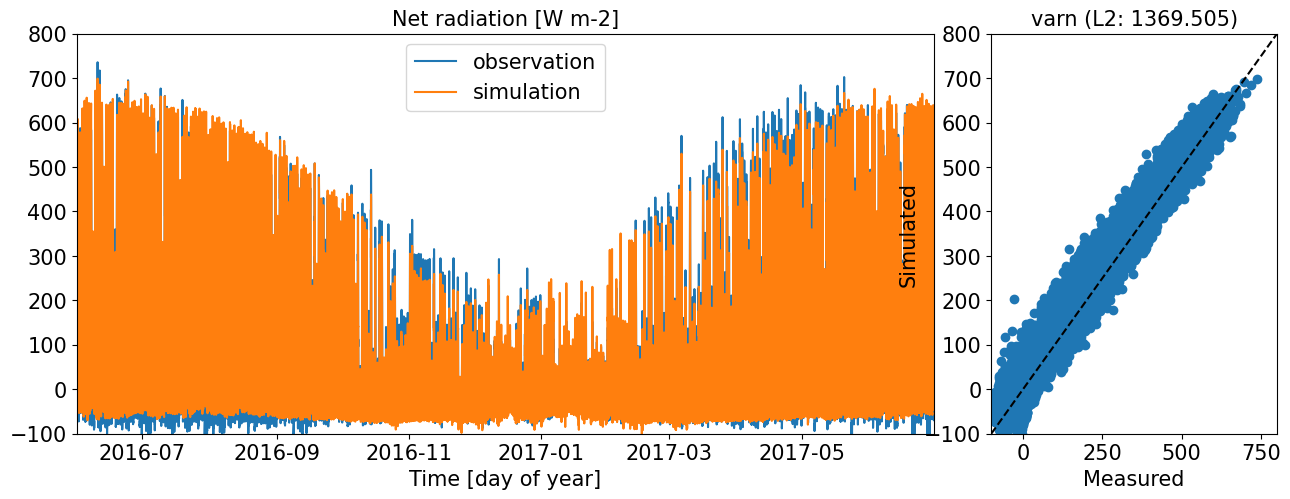

In [41]:
plot_timeseries_obs_1to1(
    obs.rnet,
    can.rnet,
    lim=[-100, 800],
    met=met,
    varn="Net radiation [W m-2]",
);

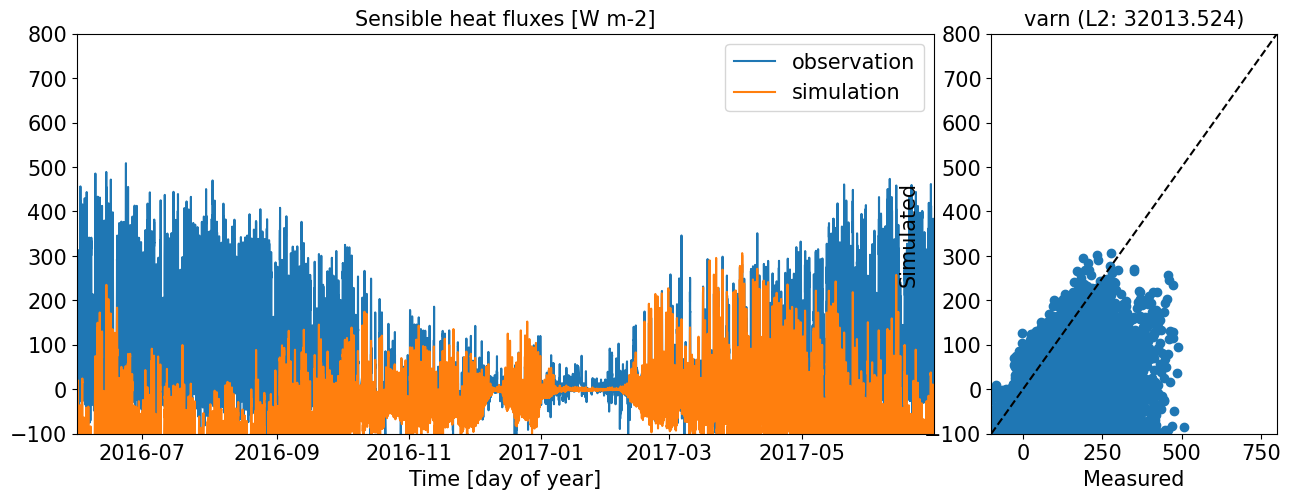

In [42]:
plot_timeseries_obs_1to1(
    obs.H,
    veg.H,
    lim=[-100, 800],
    met=met,
    varn="Sensible heat fluxes [W m-2]",
);

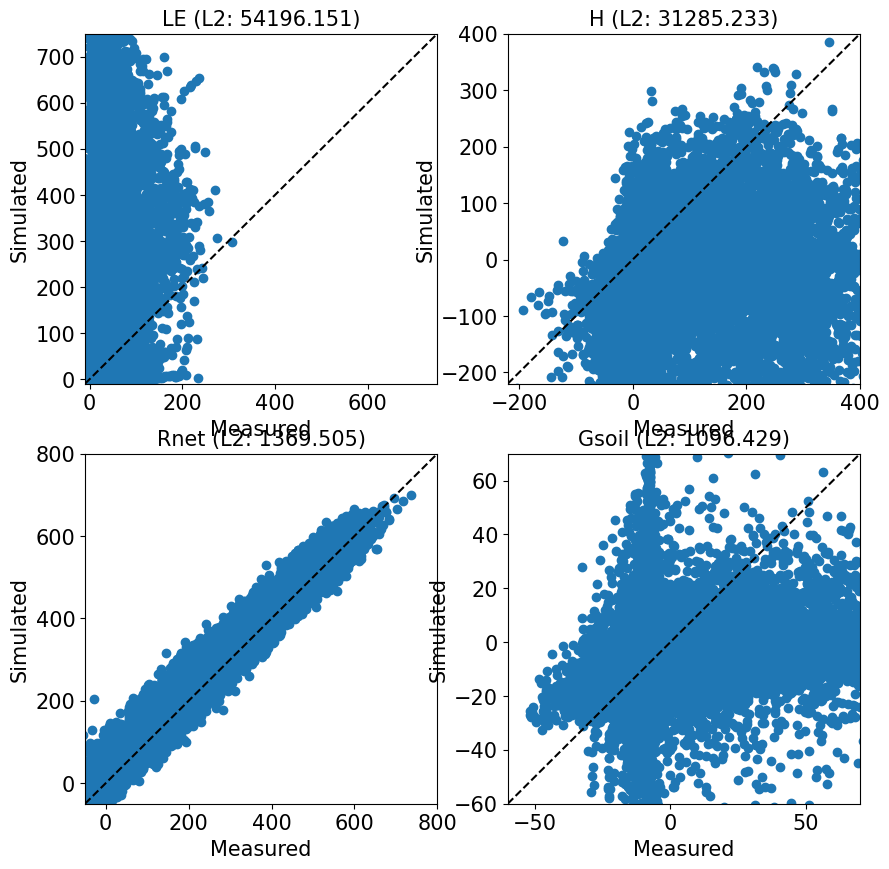

In [43]:
plot_obs_comparison(obs, can);

# Perform the parameter estimation

In [49]:
# Filter the parameters to be estimated
filter_model_spec = jtu.tree_map(lambda _: False, canoak_eqx)
filter_model_spec = eqx.tree_at(
    lambda t: (t.para.vcopt, t.para.jmopt),
    filter_model_spec,
    replace=(True, True),
)

In [51]:
nsteps = 10  # number of epoches
y = obs.rnet  # observations
optim = optax.adam(learning_rate=0.01)  # Adam optimizer
canoak_eqx_new, loss_set = perform_optimization(
    canoak_eqx.get_can_le, filter_model_spec.get_can_le, optim, y, met, nsteps
)
canoak_eqx_new = canoak_eqx_new.args[0]

: 

: 